# Imports

In [153]:
import pandas as pd
import re
import py_stringmatching.similarity_measure.jaro as jaro
import py_stringmatching

# Reading the cleaned csvs

In [154]:
us_accidents = pd.read_csv("./Cleaned Datasets/us_accidents_cleaned.csv", index_col=[0])
nba = pd.read_csv("./Cleaned Datasets/team_cleaned.csv", index_col=[0])
pollution = pd.read_csv("./Cleaned Datasets/pollution_cleaned.csv", index_col=[0])
nba_teams = pd.read_csv("./Cleaned Datasets/nba_elo_cleaned.csv", index_col=[0])

In [155]:
us_accidents

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Start_Lat,Start_Lng
0,3,2016-02-08 05:46:00,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.865147,-84.058723
1,2,2016-02-08 06:07:59,REYNOLDSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.928059,-82.831184
2,2,2016-02-08 06:49:27,WILLIAMSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.063148,-84.032608
3,3,2016-02-08 07:23:34,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.747753,-84.205582
4,2,2016-02-08 07:39:07,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.627781,-84.188354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,2,2019-08-23 18:03:25,RIVERSIDE,CA,False,False,False,False,False,False,False,False,False,False,False,False,34.002480,-117.379360
7728390,2,2019-08-23 19:11:30,SANDIEGO,CA,False,False,False,False,False,False,False,False,False,False,False,False,32.766960,-117.148060
7728391,2,2019-08-23 19:00:21,ORANGE,CA,False,False,False,False,True,False,False,False,False,False,False,False,33.775450,-117.847790
7728392,2,2019-08-23 19:00:21,CULVERCITY,CA,False,False,False,False,False,False,False,False,False,False,False,False,33.992460,-118.403020


# Creation of the data marts

## Game Impact Mart

This data mart will have all the data necessary to analyze and answer our main question for this project.

To build it, we'll require all the datasets we accquired thus far.

In [156]:
us_state_name_to_abbrev = {
    'ALABAMA': 'AL',
    'ALASKA': 'AK',
    'ARIZONA': 'AZ',
    'ARKANSAS': 'AR',
    'CALIFORNIA': 'CA',
    'COLORADO': 'CO',
    'CONNECTICUT': 'CT',
    'DELAWARE': 'DE',
    'FLORIDA': 'FL',
    'GEORGIA': 'GA',
    'HAWAII': 'HI',
    'IDAHO': 'ID',
    'ILLINOIS': 'IL',
    'INDIANA': 'IN',
    'IOWA': 'IA',
    'KANSAS': 'KS',
    'KENTUCKY': 'KY',
    'LOUISIANA': 'LA',
    'MAINE': 'ME',
    'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA',
    'MICHIGAN': 'MI',
    'MINNESOTA': 'MN',
    'MISSISSIPPI': 'MS',
    'MISSOURI': 'MO',
    'MONTANA': 'MT',
    'NEBRASKA': 'NE',
    'NEVADA': 'NV',
    'NEWHAMPSHIRE': 'NH',
    'NEWJERSEY': 'NJ',
    'NEWMEXICO': 'NM',
    'NEWYORK': 'NY',
    'NORTHCAROLINA': 'NC',
    'NORTHDAKOTA': 'ND',
    'OHIO': 'OH',
    'OKLAHOMA': 'OK',
    'OREGON': 'OR',
    'PENNSYLVANIA': 'PA',
    'RHODEISLAND': 'RI',
    'SOUTHCAROLINA': 'SC',
    'SOUTHDAKOTA': 'SD',
    'TENNESSEE': 'TN',
    'TEXAS': 'TX',
    'UTAH': 'UT',
    'VERMONT': 'VT',
    'VIRGINIA': 'VA',
    'WASHINGTON': 'WA',
    'WESTVIRGINIA': 'WV',
    'WISCONSIN': 'WI',
    'WYOMING': 'WY',
    'DISTRICTOFCOLUMBIA': 'DC'
}


In [157]:
nba_teams["state"] = nba_teams["state"].apply(lambda x: us_state_name_to_abbrev[x].upper())

In [158]:
for index in nba.index:
    score1 = nba.loc[index, "score1"]
    score2 = nba.loc[index, "score2"]
    if score1 > score2:
        nba.loc[index, "loser"] = nba.loc[index, "team2"]
        nba.loc[index, "winner"] = nba.loc[index, "team1"]
    if score2 > score1:
        nba.loc[index, "loser"] = nba.loc[index, "team1"]
        nba.loc[index, "winner"] = nba.loc[index, "team2"]
        
nba = nba.dropna(subset=['loser'])
del nba_teams["id"]

### Matching team information to NBA match loser team

In [159]:
nba_teams

,full_name,abbreviation,nickname,city,state,year_founded
0,ATLANTAHAWKS,ATL,HAWKS,ATLANTA,AK,1949.0
1,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
2,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
3,NEWORLEANSPELICANS,NOP,PELICANS,NEWORLEANS,LA,2002.0
4,CHICAGOBULLS,CHI,BULLS,CHICAGO,IL,1966.0
5,DALLASMAVERICKS,DAL,MAVERICKS,DALLAS,TX,1980.0
6,DENVERNUGGETS,DEN,NUGGETS,DENVER,CO,1976.0
7,GOLDENSTATEWARRIORS,GSW,WARRIORS,GOLDENSTATE,CA,1946.0
8,HOUSTONROCKETS,HOU,ROCKETS,HOUSTON,TX,1967.0
9,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0


In [160]:
nba['matches'] = [[] for _ in range(len(nba))] 

for idx in nba.index:
    for abbr in nba_teams.abbreviation.values:
        abbr_score = jaro.Jaro().get_sim_score(nba.loc[idx, "loser"], abbr)

        if abbr_score >= 0.8:
            nba.loc[idx, "matches"].append(abbr)
nba

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,carmelo2_pre,carmelo1_post,carmelo2_post,carmelo_prob1,carmelo_prob2,score1,score2,loser,winner,matches
0,0,1946-11-01,1947,0,False,TRH,NYK,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,66.0,68.0,TRH,NYK,[]
1,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,NaN,NaN,NaN,NaN,NaN,63.0,47.0,NYK,CHS,[NYK]
2,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,59.0,53.0,BOS,PRO,[BOS]
3,3,1946-11-02,1947,0,False,STB,PIT,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,56.0,51.0,PIT,STB,[]
4,4,1946-11-02,1947,0,False,DTF,WSC,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,33.0,50.0,DTF,WSC,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67007,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,1518.775821,1670.684530,1507.976699,0.746325,0.253675,130.0,95.0,MIL,PHI,[MIL]
67008,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,1353.366271,1551.305868,1380.535101,0.865447,0.134553,98.0,110.0,CLE,NYK,[CLE]
67009,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,1776.681162,1355.612647,1748.389768,0.138616,0.861384,96.0,83.0,HOU,SAC,[HOU]
67010,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,1685.253159,1618.401111,1677.637894,0.589215,0.410785,102.0,93.0,UTA,POR,[UTA]


1st Data fusion strategy: If more than two teams match with the same abbreviation, we keep the most recently founded team's info. This is due to the fact that there are some old teams whose match data won't match to any of the US accidents data.

In [161]:
match_conflicts = nba[nba['matches'].apply(lambda x: len(x) > 1)]

for idx in match_conflicts.index:
    most_recent = None
    for match in match_conflicts.loc[idx, "matches"]:
        year = nba_teams[nba_teams["abbreviation"] == match].year

        if year > most_recent:
            most_recent = match
    nba.loc[idx, "matches"] = [most_recent]

Keeping only rows where there were matches:

In [162]:
nba = nba[nba['matches'].apply(lambda x: len(x) > 0)]

Removing the match from the list:

In [163]:
nba['matches'] = nba['matches'].apply(lambda x: x[0])
nba

/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_36840/889968744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba['matches'] = nba['matches'].apply(lambda x: x[0])


,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,carmelo2_pre,carmelo1_post,carmelo2_post,carmelo_prob1,carmelo_prob2,score1,score2,loser,winner,matches
1,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,NaN,NaN,NaN,NaN,NaN,63.0,47.0,NYK,CHS,NYK
2,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,NaN,NaN,NaN,NaN,NaN,59.0,53.0,BOS,PRO,BOS
7,7,1946-11-05,1947,0,False,BOS,CHS,1294.845800,1309.652100,0.620204,...,NaN,NaN,NaN,NaN,NaN,55.0,57.0,BOS,CHS,BOS
16,16,1946-11-09,1947,0,False,DTF,BOS,1268.446800,1288.413900,0.613182,...,NaN,NaN,NaN,NaN,NaN,69.0,46.0,BOS,DTF,BOS
18,18,1946-11-11,1947,0,False,NYK,CHS,1307.319700,1315.252200,0.629479,...,NaN,NaN,NaN,NaN,NaN,68.0,78.0,NYK,CHS,NYK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67007,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,1518.775821,1670.684530,1507.976699,0.746325,0.253675,130.0,95.0,MIL,PHI,MIL
67008,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,1353.366271,1551.305868,1380.535101,0.865447,0.134553,98.0,110.0,CLE,NYK,CLE
67009,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,1776.681162,1355.612647,1748.389768,0.138616,0.861384,96.0,83.0,HOU,SAC,HOU
67010,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,1685.253159,1618.401111,1677.637894,0.589215,0.410785,102.0,93.0,UTA,POR,UTA


Merging on the matched abbreviations we get a dataset that contains nba matches and the loser's information, which includes that state. As that is what matters for our analysis.

In [164]:
merged_nba = pd.merge(nba, nba_teams.add_prefix("loser_"), left_on="matches", right_on="loser_abbreviation", how="inner")

In [165]:
del merged_nba["matches"]

In [166]:
merged_nba

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,score1,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded
0,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,63.0,47.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0
1,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,59.0,53.0,BOS,PRO,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
2,7,1946-11-05,1947,0,False,BOS,CHS,1294.845800,1309.652100,0.620204,...,55.0,57.0,BOS,CHS,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
3,16,1946-11-09,1947,0,False,DTF,BOS,1268.446800,1288.413900,0.613182,...,69.0,46.0,BOS,DTF,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0
4,18,1946-11-11,1947,0,False,NYK,CHS,1307.319700,1315.252200,0.629479,...,68.0,78.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46632,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,130.0,95.0,MIL,PHI,MILWAUKEEBUCKS,MIL,BUCKS,MILWAUKEE,WI,1968.0
46633,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,98.0,110.0,CLE,NYK,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
46634,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,96.0,83.0,HOU,SAC,HOUSTONROCKETS,HOU,ROCKETS,HOUSTON,TX,1967.0
46635,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,102.0,93.0,UTA,POR,UTAHJAZZ,UTA,JAZZ,UTAH,UT,1974.0


### Matching US Accidents data to NBA loser teams' losses

In [167]:
merged_nba.columns

Index(['index', 'date', 'season', 'neutral', 'playoff', 'team1', 'team2',
       'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post',
       'elo2_post', 'carmelo1_pre', 'carmelo2_pre', 'carmelo1_post',
       'carmelo2_post', 'carmelo_prob1', 'carmelo_prob2', 'score1', 'score2',
       'loser', 'winner', 'loser_full_name', 'loser_abbreviation',
       'loser_nickname', 'loser_city', 'loser_state', 'loser_year_founded'],
      dtype='object')

In [168]:
us_accidents.columns

Index(['Severity', 'Start_Time', 'City', 'State', 'Amenity', 'Bump',
       'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout',
       'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Start_Lat',
       'Start_Lng'],
      dtype='object')

In [169]:
merged_nba["blocking"] = merged_nba.apply(lambda row: row["date"] + row["loser_state"], axis=1)
merged_nba

,index,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,blocking
0,1,1946-11-02,1947,0,False,CHS,NYK,1300.000000,1306.723300,0.631101,...,47.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0,1946-11-02NY
1,2,1946-11-02,1947,0,False,PRO,BOS,1300.000000,1300.000000,0.640065,...,53.0,BOS,PRO,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0,1946-11-02MA
2,7,1946-11-05,1947,0,False,BOS,CHS,1294.845800,1309.652100,0.620204,...,57.0,BOS,CHS,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0,1946-11-05MA
3,16,1946-11-09,1947,0,False,DTF,BOS,1268.446800,1288.413900,0.613182,...,46.0,BOS,DTF,BOSTONCELTICS,BOS,CELTICS,BOSTON,MA,1946.0,1946-11-09MA
4,18,1946-11-11,1947,0,False,NYK,CHS,1307.319700,1315.252200,0.629479,...,78.0,NYK,CHS,NEWYORKKNICKS,NYK,KNICKS,NEWYORK,NY,1946.0,1946-11-11NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46632,67007,2018-04-11,2018,0,False,PHI,MIL,1651.670164,1522.789678,0.788772,...,95.0,MIL,PHI,MILWAUKEEBUCKS,MIL,BUCKS,MILWAUKEE,WI,1968.0,2018-04-11WI
46633,67008,2018-04-11,2018,0,False,CLE,NYK,1579.727989,1350.312469,0.869469,...,110.0,CLE,NYK,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,2018-04-11OH
46634,67009,2018-04-11,2018,0,False,SAC,HOU,1331.355896,1761.165813,0.130274,...,83.0,HOU,SAC,HOUSTONROCKETS,HOU,ROCKETS,HOUSTON,TX,1967.0,2018-04-11TX
46635,67010,2018-04-11,2018,0,False,POR,UTA,1604.852723,1695.749505,0.513098,...,93.0,UTA,POR,UTAHJAZZ,UTA,JAZZ,UTAH,UT,1974.0,2018-04-11UT


In [173]:
us_accidents["blocking"] = us_accidents.apply(lambda row: row["Start_Time"].split(" ")[0] + row["State"], axis=1)
us_accidents 

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Start_Lat,Start_Lng,blocking
0,3,2016-02-08 05:46:00,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.865147,-84.058723,2016-02-08OH
1,2,2016-02-08 06:07:59,REYNOLDSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.928059,-82.831184,2016-02-08OH
2,2,2016-02-08 06:49:27,WILLIAMSBURG,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.063148,-84.032608,2016-02-08OH
3,3,2016-02-08 07:23:34,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,False,39.747753,-84.205582,2016-02-08OH
4,2,2016-02-08 07:39:07,DAYTON,OH,False,False,False,False,False,False,False,False,False,False,False,True,39.627781,-84.188354,2016-02-08OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,2,2019-08-23 18:03:25,RIVERSIDE,CA,False,False,False,False,False,False,False,False,False,False,False,False,34.002480,-117.379360,2019-08-23CA
7728390,2,2019-08-23 19:11:30,SANDIEGO,CA,False,False,False,False,False,False,False,False,False,False,False,False,32.766960,-117.148060,2019-08-23CA
7728391,2,2019-08-23 19:00:21,ORANGE,CA,False,False,False,False,True,False,False,False,False,False,False,False,33.775450,-117.847790,2019-08-23CA
7728392,2,2019-08-23 19:00:21,CULVERCITY,CA,False,False,False,False,False,False,False,False,False,False,False,False,33.992460,-118.403020,2019-08-23CA


In [174]:
blocking_matches = us_accidents.merge(merged_nba, on='blocking')
blocking_matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score1,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded
0,2,2016-02-22 05:20:31,DAYTON,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
1,2,2016-02-22 06:11:53,BOWLINGGREEN,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
2,2,2016-02-22 06:54:32,REYNOLDSBURG,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
3,2,2016-02-22 07:09:58,COLUMBUS,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
4,2,2016-02-22 07:14:44,CANALWINCHESTER,OH,False,False,False,False,False,False,...,88.0,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349835,2,2017-10-30 19:44:00,SALINAS,CA,False,False,False,True,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0
349838,2,2017-10-30 21:24:07,LOSANGELES,CA,False,False,False,False,False,False,...,113.0,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0


In [175]:
leven = py_stringmatching.Levenshtein()
jaro = py_stringmatching.Jaro()

def similarity_accident_game(acc_city, acc_state, nba_city, nba_state):
    state_score = jaro.get_sim_score(nba_state, acc_state)
    city_score = leven.get_sim_score(nba_city, acc_city)
    score = state_score * 0.5 + city_score * 0.5
    return score

In [176]:
blocking_matches['similarity'] = blocking_matches.apply(
    lambda row: similarity_accident_game(row["City"], row["State"], row["loser_city"], row["loser_state"]), axis=1
)
blocking_matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,similarity
0,2,2016-02-22 05:20:31,DAYTON,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.555556
1,2,2016-02-22 06:11:53,BOWLINGGREEN,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.541667
2,2,2016-02-22 06:54:32,REYNOLDSBURG,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.541667
3,2,2016-02-22 07:09:58,COLUMBUS,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.555556
4,2,2016-02-22 07:14:44,CANALWINCHESTER,OH,False,False,False,False,False,False,...,96.0,CLE,DET,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349835,2,2017-10-30 19:44:00,SALINAS,CA,False,False,False,True,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,0.650000
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.000000
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.000000
349838,2,2017-10-30 21:24:07,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.000000


In [177]:
matches = blocking_matches[blocking_matches['similarity'] >= 0.75].copy()
matches

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,similarity
40,3,2016-03-07 07:27:39,CLEVELAND,OH,False,False,False,False,False,False,...,106.0,CLE,MEM,CLEVELANDCAVALIERS,CLE,CAVALIERS,CLEVELAND,OH,1970.0,1.00
348,2,2016-12-02 02:51:52,LOSALTOS,CA,False,False,False,False,False,False,...,80.0,LAL,TOR,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,0.75
384,2,2016-12-02 09:14:27,LOSGATOS,CA,False,False,False,True,False,False,...,80.0,LAL,TOR,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,0.75
409,2,2016-12-02 09:53:29,SACRAMENTO,CA,False,False,False,False,False,False,...,92.0,SAC,BOS,SACRAMENTOKINGS,SAC,KINGS,SACRAMENTO,CA,1948.0,1.00
451,2,2016-12-02 12:11:01,SACRAMENTO,CA,False,False,True,False,False,False,...,92.0,SAC,BOS,SACRAMENTOKINGS,SAC,KINGS,SACRAMENTO,CA,1948.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349821,2,2017-10-30 16:56:01,ORANGE,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,0.75
349836,2,2017-10-30 21:22:15,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00
349837,2,2017-10-30 21:26:00,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00
349838,2,2017-10-30 21:24:07,LOSANGELES,CA,False,False,False,False,False,False,...,141.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.00


In [184]:
matches["Start_Time"].value_counts()

Start_Time
2017-02-02 08:46:53    12
2017-02-02 19:06:31    10
2016-12-23 14:52:57     8
2017-12-06 06:04:10     8
2016-11-23 07:50:52     6
                       ..
2017-02-27 18:04:52     1
2017-02-27 18:05:17     1
2017-02-27 18:25:10     1
2017-02-27 18:24:50     1
2017-10-30 21:24:07     1
Name: count, Length: 40042, dtype: int64

In [ ]:
conflicts = matches["Start_Time"].value_counts()
conflicts = conflicts[conflicts >= 2]

All of these represent fusion conflicts.

In [196]:
for date in conflicts.index:
    not_conflicts = matches[matches["Start_Time"] == date].State.unique()

    if len(not_conflicts) > 2:
        print(date)

In [198]:
matches[ matches["Start_Time"] == "2017-02-02 08:46:53" ]

,Severity,Start_Time,City,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,score2,loser,winner,loser_full_name,loser_abbreviation,loser_nickname,loser_city,loser_state,loser_year_founded,similarity
304173,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,False,False,...,108.0,LAL,WAS,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,1.0
304174,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,False,False,...,133.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.0
304175,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,True,False,...,108.0,LAL,WAS,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,1.0
304176,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,True,False,...,133.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.0
304177,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,True,False,...,108.0,LAL,WAS,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,1.0
304178,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,True,False,...,133.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.0
304179,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,False,False,...,108.0,LAL,WAS,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,1.0
304180,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,False,False,...,133.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.0
304183,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,False,False,...,108.0,LAL,WAS,LOSANGELESLAKERS,LAL,LAKERS,LOSANGELES,CA,1948.0,1.0
304184,3,2017-02-02 08:46:53,LOSANGELES,CA,False,False,False,False,False,False,...,133.0,LAC,GSW,LOSANGELESCLIPPERS,LAC,CLIPPERS,LOSANGELES,CA,1970.0,1.0


In [82]:
us_accidents['date'] = pd.to_datetime(us_accidents['date'])
merged['date'] = pd.to_datetime(merged['date'])

In [83]:
# NBA_Team: [["abbreviation", "state", "city"]]
# NBA_Game: [["date", "playoff", "team1", "team2", "score1", "score2"]]
# Location: [["city", "state", "zipcode", "latitude", "longitude"]]
# Accident:
# Road_Conditions:

# NBA_Team -> NBA_Game -> Location
accidents_nba = pd.merge(
    merged,
    us_accidents,
    left_on=['State', 'date'],
    right_on=['State', 'date'],
    how='inner'
)
accidents_nba.columns

Index(['index', 'date', 'season', 'neutral', 'playoff', 'team1', 'team2',
       'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post',
       'elo2_post', 'carmelo1_pre', 'carmelo2_pre', 'carmelo1_post',
       'carmelo2_post', 'carmelo_prob1', 'carmelo_prob2', 'score1', 'score2',
       'loser', 'winner', 'loser_full_name', 'loser_nickname', 'loser_city',
       'State', 'loser_year_founded', 'winner_full_name', 'winner_nickname',
       'winner_city', 'winner_state', 'winner_year_founded', 'Severity',
       'City', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
       'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Start_Lat', 'Start_Lng'],
      dtype='object')

In [84]:
del accidents_nba["index"]

In [85]:
game_dates = accidents_nba.date.dt.year.unique()

In [86]:
us_accidents_no_game = us_accidents[~us_accidents['date'].isin(game_dates)]

In [87]:
accidents_nba.date.values
list(map(lambda x: str(x).split("-")[0], accidents_nba.date.values))
pd.Series(list(map(lambda x: str(x).split("-")[0], accidents_nba.date.values))).unique()

array(['2016', '2017', '2018'], dtype=object)

In [88]:
us_accidents_no_game = us_accidents_no_game[us_accidents_no_game["date"].dt.year.isin([2016, 2017, 2018])]

In [91]:
accidents_nba_playoffs = accidents_nba.query("playoff == True")

In [92]:
print("Number of accidents in no NBA game days: {0}".format(us_accidents_no_game.shape[0]))
print("Number of accidents in NBA game days: {0}".format(accidents_nba.shape[0]))
print("Number of accidents in NBA game days: {0}".format(accidents_nba_playoffs.shape[0]))

Number of accidents in no NBA game days: 2012663
Number of accidents in NBA game days: 326386
Number of accidents in NBA game days: 13936


In [21]:
accidents_by_day = accidents_nba.groupby(['date', 'State']).size().reset_index(name='accident_count')
accidents_by_day

,date,State,accident_count
0,2016-01-14,PA,1
1,2016-02-10,PA,3
2,2016-02-22,IN,2
3,2016-02-22,OH,48
4,2016-02-23,PA,2
...,...,...,...
1794,2018-04-11,OH,71
1795,2018-04-11,TN,92
1796,2018-04-11,TX,666
1797,2018-04-11,UT,16


In [22]:
accidents_by_day.State.unique()

array(['PA', 'IN', 'OH', 'CA', 'NY', 'MA', 'MI', 'UT', 'FL', 'LA', 'MN',
       'TX', 'OR', 'CO', 'TN', 'WI', 'IL', 'OK', 'MT'], dtype=object)

In [93]:
accidents_by_day_playoffs = accidents_nba_playoffs.groupby(['date', 'State']).size().reset_index(name='accident_count')
accidents_by_day_playoffs

,date,State,accident_count
0,2016-04-18,IN,2
1,2016-04-19,MA,1
2,2016-04-21,CA,672
3,2016-04-21,IN,2
4,2016-04-22,MI,1
...,...,...,...
84,2017-06-01,OH,33
85,2017-06-04,OH,13
86,2017-06-07,OH,31
87,2017-06-09,CA,508


In [23]:
accidents_by_no_game_day = us_accidents_no_game.groupby(['date', 'State']).size().reset_index(name='accident_count')
accidents_by_no_game_day

,date,State,accident_count
0,2016-01-14,PA,1
1,2016-02-08,IN,1
2,2016-02-08,KY,1
3,2016-02-08,OH,58
4,2016-02-09,IN,10
...,...,...,...
37613,2018-12-31,TX,260
37614,2018-12-31,UT,55
37615,2018-12-31,VA,105
37616,2018-12-31,WA,38


In [24]:
accidents_by_no_game_day = accidents_by_no_game_day[accidents_by_no_game_day["State"].isin(accidents_by_day.State.unique())]
accidents_by_no_game_day

,date,State,accident_count
0,2016-01-14,PA,1
1,2016-02-08,IN,1
3,2016-02-08,OH,58
4,2016-02-09,IN,10
5,2016-02-09,MI,2
...,...,...,...
37608,2018-12-31,PA,70
37612,2018-12-31,TN,41
37613,2018-12-31,TX,260
37614,2018-12-31,UT,55


In [25]:
accidents_by_no_game_day = accidents_by_no_game_day[~accidents_by_no_game_day.date.dt.month.isin([7, 8, 9])]
accidents_by_no_game_day

,date,State,accident_count
0,2016-01-14,PA,1
1,2016-02-08,IN,1
3,2016-02-08,OH,58
4,2016-02-09,IN,10
5,2016-02-09,MI,2
...,...,...,...
37608,2018-12-31,PA,70
37612,2018-12-31,TN,41
37613,2018-12-31,TX,260
37614,2018-12-31,UT,55


# Analysis of the data

In [94]:
avg_accidents_per_no_game_day = accidents_by_no_game_day.accident_count.sum() / accidents_by_no_game_day.shape[0]
avg_accidents_per_game_day= accidents_by_day.accident_count.sum() / accidents_by_day.shape[0]
avg_accidents_per_playoff_day= accidents_by_day_playoffs.accident_count.sum() / accidents_by_day_playoffs.shape[0]

In [95]:
print("Average accidents on non NBA game days: {0:.3f}".format(avg_accidents_per_no_game_day))
print("Average accidents on NBA game loss days: {0:.3f}".format(avg_accidents_per_game_day))
print("Average accidents on NBA playoff game loss days: {0:.3f}".format(avg_accidents_per_playoff_day))

Average accidents on non NBA game days: 85.711
Average accidents on NBA game loss days: 181.426
Average accidents on NBA playoff game loss days: 156.584


In [28]:
accidents_by_day

,date,State,accident_count
0,2016-01-14,PA,1
1,2016-02-10,PA,3
2,2016-02-22,IN,2
3,2016-02-22,OH,48
4,2016-02-23,PA,2
...,...,...,...
1794,2018-04-11,OH,71
1795,2018-04-11,TN,92
1796,2018-04-11,TX,666
1797,2018-04-11,UT,16


In [29]:
accidents_by_day.describe()

,date,accident_count
count,1799,1799.000000
mean,2017-06-22 17:47:47.593107456,181.426348
min,2016-01-14 00:00:00,1.000000
25%,2017-01-06 00:00:00,13.000000
50%,2017-04-12 00:00:00,62.000000
75%,2018-01-04 12:00:00,231.500000
max,2018-04-11 00:00:00,2214.000000
std,NaN,284.564220


In [30]:
accidents_by_no_game_day.describe()

,date,accident_count
count,11947,11947.000000
mean,2017-09-23 20:43:17.472168704,85.711141
min,2016-01-14 00:00:00,1.000000
25%,2017-02-08 00:00:00,9.000000
50%,2017-11-06 00:00:00,39.000000
75%,2018-04-19 00:00:00,97.000000
max,2018-12-31 00:00:00,940.000000
std,NaN,127.532145


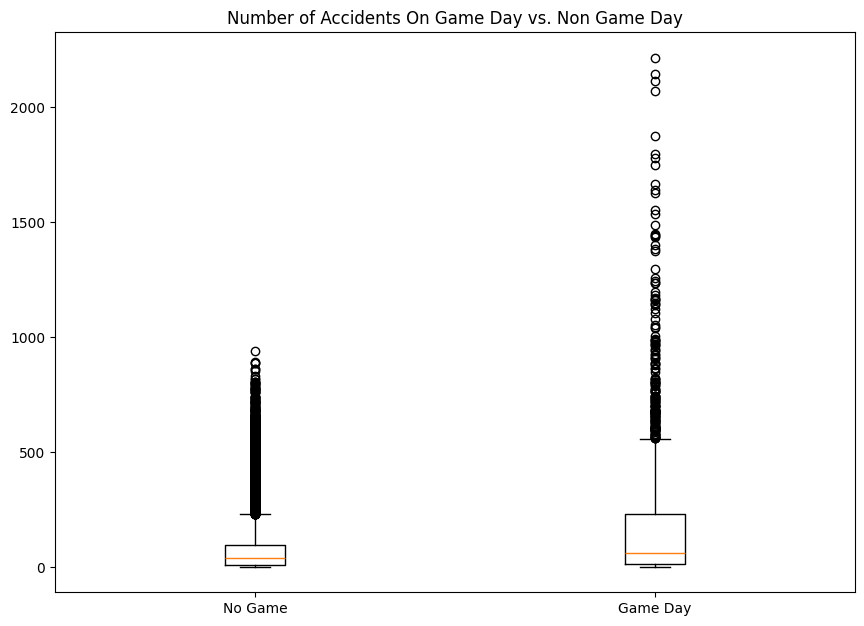

In [31]:
import matplotlib.pyplot as plt

d_1 = accidents_by_no_game_day.accident_count.values
d_2 = accidents_by_day.accident_count.values

d = [d_1, d_2]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
bp = ax.boxplot(d)

plt.title("Number of Accidents On Game Day vs. Non Game Day")
plt.xticks(ticks=[1, 2], labels=["No Game", "Game Day"])
plt.show()

In [32]:
state_count = accidents_by_day[["State", "accident_count"]].groupby("State").size()

<Axes: xlabel='State'>

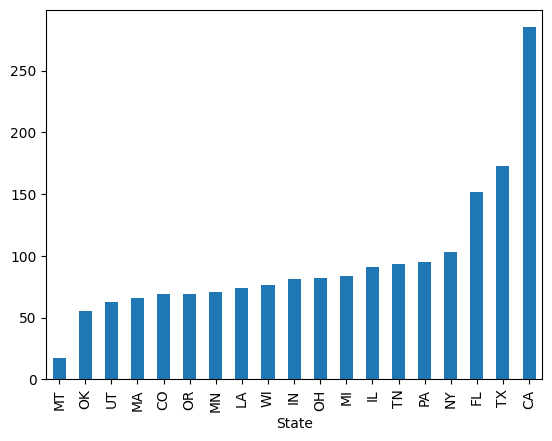

In [33]:
state_count.sort_values().plot.bar()

<Axes: xlabel='State'>

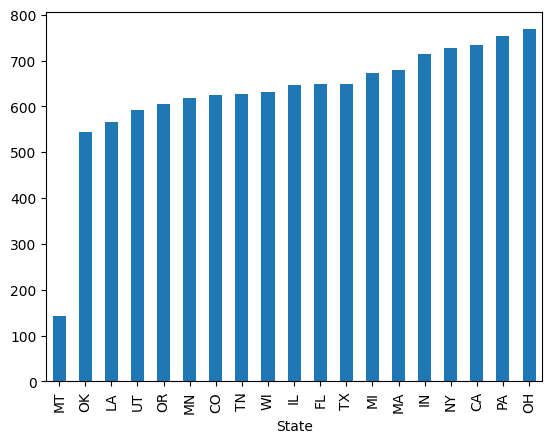

In [34]:
accidents_by_no_game_day[["State", "accident_count"]].groupby("State").size().sort_values().plot.bar()

In [35]:
accidents_by_day["month"] = accidents_by_day.date.dt.month
accidents_by_day["year"] = accidents_by_day.date.dt.year

accidents_by_no_game_day["month"] = accidents_by_no_game_day.date.dt.month
accidents_by_no_game_day["year"] = accidents_by_no_game_day.date.dt.year

/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_1724/1112402550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_by_no_game_day["month"] = accidents_by_no_game_day.date.dt.month
/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_1724/1112402550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accidents_by_no_game_day["year"] = accidents_by_no_game_day.date.dt.year


In [36]:
teste = accidents_by_day[["State", "accident_count", "month", "year"]].groupby(["month", "year"]).size()
teste2 = accidents_by_no_game_day[["State", "accident_count", "month", "year"]].groupby(["month", "year"]).size()

In [37]:
teste2

month  year
1      2016      1
       2017    525
       2018    572
2      2016     64
       2017    478
       2018    516
3      2016    108
       2017    521
       2018    560
4      2016    162
       2017    498
       2018    541
5      2016    152
       2017    498
       2018    560
6      2016    293
       2017    481
       2018    542
10     2016    497
       2017    558
       2018    562
11     2016    513
       2017    541
       2018    543
12     2016    534
       2017    562
       2018    565
dtype: int64

Some observations:
* Months 7, 8, 9 don't have official NBA games.
* Months 6, 10 don't have a lot of games.

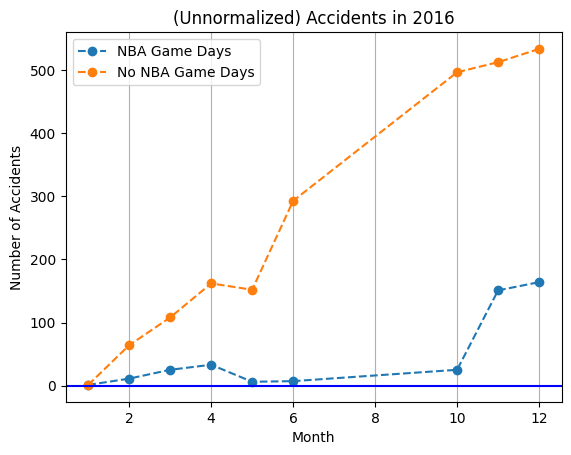

In [38]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2016_nba = [teste[i][2016] if i in teste and 2016 in teste[i] else 0 for i in months]
values_2016_no_nba = [ teste2[i, 2016] if i in teste2 and 2016 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2016_nba, '--o')
plt.plot(months, values_2016_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("(Unnormalized) Accidents in 2016")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

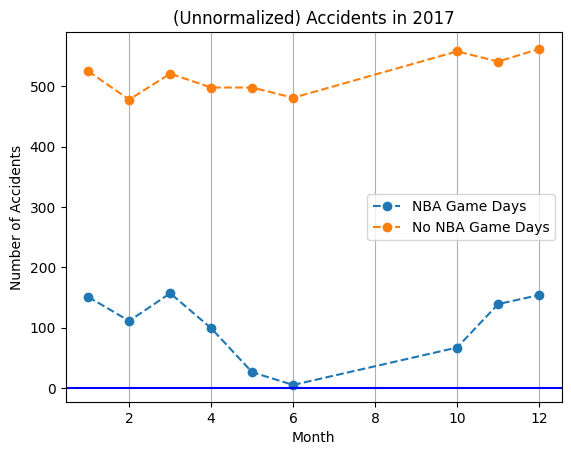

In [39]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2017_nba = [teste[i][2017] if i in teste and 2017 in teste[i] else 0 for i in months]
values_2017_no_nba = [ teste2[i, 2017] if i in teste2 and 2017 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2017_nba, '--o')
plt.plot(months, values_2017_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("(Unnormalized) Accidents in 2017")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

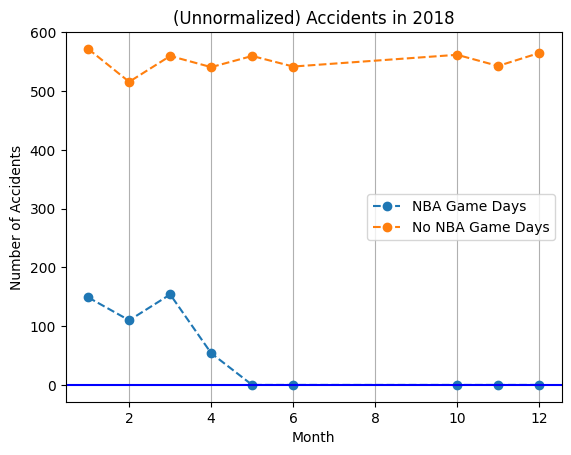

In [40]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2018_nba = [teste[i][2018] if i in teste and 2018 in teste[i] else 0 for i in months]
values_2018_no_nba = [ teste2[i, 2018] if i in teste2 and 2018 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2018_nba, '--o')
plt.plot(months, values_2018_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.title("(Unnormalized) Accidents in 2018")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

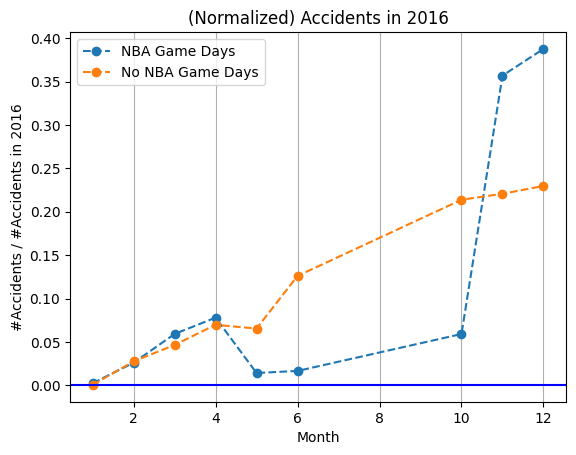

In [41]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2016_nba = [teste[i][2016] / teste.xs(2016, level='year').sum() if i in teste and 2016 in teste[i] else 0 for i in months]
values_2016_no_nba = [ teste2[i, 2016] / teste2.xs(2016, level='year').sum() if i in teste2 and 2016 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2016_nba, '--o')
plt.plot(months, values_2016_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("#Accidents / #Accidents in 2016")
plt.title("(Normalized) Accidents in 2016")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

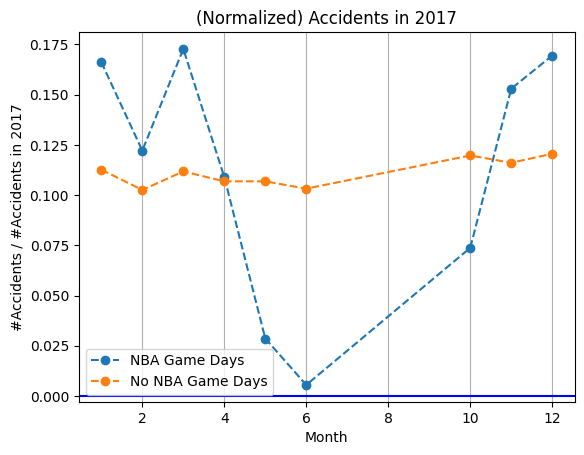

In [42]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2017_nba = [teste[i][2017] / teste.xs(2017, level='year').sum() if i in teste and 2017 in teste[i] else 0 for i in months]
values_2017_no_nba = [ teste2[i, 2017] / teste2.xs(2017, level='year').sum() if i in teste2 and 2017 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2017_nba, '--o')
plt.plot(months, values_2017_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("#Accidents / #Accidents in 2017")
plt.title("(Normalized) Accidents in 2017")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

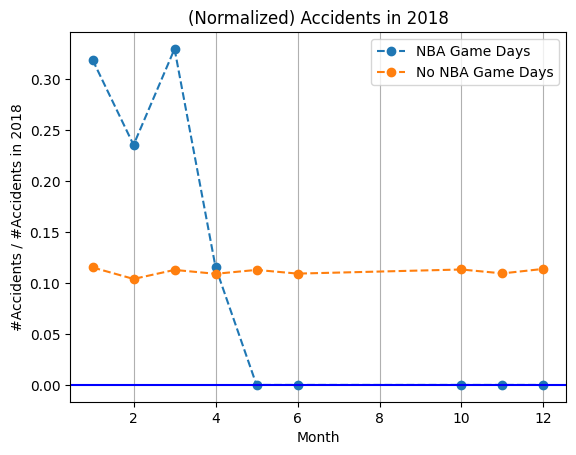

In [43]:
months = [1, 2, 3, 4, 5, 6, 10, 11, 12]
values_2018_nba = [teste[i][2018] / teste.xs(2018, level='year').sum() if i in teste and 2018 in teste[i] else 0 for i in months]
values_2018_no_nba = [ teste2[i, 2018] / teste2.xs(2018, level='year').sum() if i in teste2 and 2018 in teste2[i] else 0 for i in months ]

plt.plot(months, values_2018_nba, '--o')
plt.plot(months, values_2018_no_nba, '--o')
plt.xlabel("Month")
plt.ylabel("#Accidents / #Accidents in 2018")
plt.title("(Normalized) Accidents in 2018")
plt.grid(axis = 'x')
plt.legend(['NBA Game Days', "No NBA Game Days"]) 
plt.axhline(y=0, color='b', linestyle='-')

plt.show()

4. Choropleth (State-Level Heat Map)

What: Color U.S. states by:
Average accidents per NBA loss day
Difference between NBA-loss and non-NBA days
Why: Highlights geographical patterns and hotspots.

In [44]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [45]:
accidents_by_day

,date,State,accident_count,month,year
0,2016-01-14,PA,1,1,2016
1,2016-02-10,PA,3,2,2016
2,2016-02-22,IN,2,2,2016
3,2016-02-22,OH,48,2,2016
4,2016-02-23,PA,2,2,2016
...,...,...,...,...,...
1794,2018-04-11,OH,71,4,2018
1795,2018-04-11,TN,92,4,2018
1796,2018-04-11,TX,666,4,2018
1797,2018-04-11,UT,16,4,2018


In [46]:
teste_mapa = accidents_by_day.groupby(["State", "year"]).size().xs(2017, level="year")
teste_mapa2 = accidents_by_no_game_day.groupby(["State", "year"]).size().xs(2017, level="year")

diff = teste_mapa2.apply(lambda x: x / teste_mapa2.sum()) - teste_mapa.apply(lambda x: x / teste_mapa.sum())
diff.values

array([-0.09325662,  0.01726621, -0.0250498 ,  0.0079535 ,  0.00980754,
        0.00039714,  0.01927953,  0.01565427,  0.01316309,  0.00146752,
        0.00575328,  0.01412516,  0.01469857,  0.01386181,  0.00663889,
        0.00296478, -0.04595189,  0.00814676,  0.01308027])

In [47]:
# Exemplo de como é suposto fazer o dataframe.
df = pd.DataFrame({
    "State": diff.index,
    "accident_diff": diff.values
})

In [48]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations='State',
    locationmode='USA-states',
    color='accident_diff',
    color_continuous_scale='RdBu',
    scope='usa',
    title='Relative Difference in Accident Proportions in 2017'
)

fig.show()


In [49]:
teste_mapa = accidents_by_day.groupby(["State", "year"]).size().xs(2016, level="year")
teste_mapa2 = accidents_by_no_game_day.groupby(["State", "year"]).size().xs(2016, level="year")

diff = teste_mapa2.apply(lambda x: x / teste_mapa2.sum()) - teste_mapa.apply(lambda x: x / teste_mapa.sum())
diff.values

array([-1.03932447e-01,  2.19215260e-03, -2.89659143e-02,  3.27042720e-03,
        1.89989950e-02, -5.11773538e-03,  2.71542095e-02,  7.36583619e-03,
        7.13797439e-03,  2.80453119e-03,  2.86678629e-02,  4.48063785e-02,
        1.32139500e-03, -4.90004598e-03,  9.66378177e-05,  1.01449364e-02,
       -2.42377819e-02,  6.48490619e-03,  6.70768179e-03])

In [50]:
df = pd.DataFrame({
    "State": diff.index,
    "accident_diff": diff.values
})

In [51]:
import plotly.express as px

fig = px.choropleth(
    df,
    locations='State',
    locationmode='USA-states',
    color='accident_diff',
    color_continuous_scale='RdBu',
    scope='usa',
    title='Relative Difference in Accident Proportions in 2016'
)

fig.show()

In [52]:
teste_mapa = accidents_by_day.groupby(["State", "year"]).size().xs(2018, level="year")
teste_mapa2 = accidents_by_no_game_day.groupby(["State", "year"]).size().xs(2018, level="year")

diff = teste_mapa2.apply(lambda x: x / teste_mapa2.sum()) - teste_mapa.apply(lambda x: x / teste_mapa.sum())
diff.values

df = pd.DataFrame({
    "State": diff.index,
    "accident_diff": diff.values
})

fig = px.choropleth(
    df,
    locations='State',
    locationmode='USA-states',
    color='accident_diff',
    color_continuous_scale='RdBu',
    scope='usa',
    title='Relative Difference in Accident Proportions in 2018'
)

fig.show()

In [69]:
accidents_nba.columns
accidents_nba = accidents_nba[["date", "State", 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction',
                               'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
                               'Traffic_Calming', 'Traffic_Signal']]
accidents_nba['year'] = accidents_nba.date.dt.year

/var/folders/cl/46_xwg1s1cv84pny0b6b2d000000gn/T/ipykernel_1724/2185217312.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
accidents_nba.query("year == 2016")

,date,State,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,year
0,2016-01-14,PA,False,False,False,False,False,False,False,False,False,False,False,False,2016
1,2016-02-10,PA,False,False,False,False,False,False,False,False,False,False,False,False,2016
2,2016-02-10,PA,False,False,False,False,False,False,False,False,False,False,False,False,2016
3,2016-02-10,PA,False,False,False,False,False,False,False,False,False,False,False,False,2016
4,2016-02-22,OH,False,False,False,False,False,False,False,False,False,False,False,False,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86541,2016-12-31,NY,False,False,False,False,False,False,False,False,False,False,False,False,2016
86542,2016-12-31,NY,False,False,False,False,False,False,False,False,False,False,False,False,2016
86543,2016-12-31,NY,False,False,False,False,False,False,False,False,False,False,False,False,2016
86544,2016-12-31,NY,False,False,False,False,True,False,False,False,False,False,False,False,2016
